In [18]:
import os
from dotenv import load_dotenv
from typing import Dict, List, Any, Optional, Annotated, Union, Literal
from enum import Enum
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage, filter_messages
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition, ToolNode

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.errors import NodeInterrupt

from IPython.display import Image, display

from langchain_core.prompts import ChatPromptTemplate

In [2]:
load_dotenv()

True

In [3]:
db = SQLDatabase.from_uri("sqlite:///../sql-support-bot/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [4]:
os.environ["LANGCHAIN_PROJECT"] = "music-store-support-demo-prep"

# Set up LLMs, state and interrupt messages

In [5]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

In [6]:
# Define the node types for our graph
class NodeType(str, Enum):
    ROUTER = "router"
    QUERY = "query"
    UPDATE = "update"
    HUMAN_APPROVAL = "human_approval"
    RESPONSE = "response"

# Define our graph state schema
class GraphState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage, SystemMessage]]
    customer_id: int
    next_node: NodeType
    tool_results: Optional[List[Dict]]
    update_proposal: Optional[Dict]
    approved: Optional[bool]
    error: Optional[str]


In [7]:
action_confirmation_interrupt_message = "This action will update the database. Please confirm that you want to proceed (yes/no)"

# Helper Functions

In [8]:
def get_last_human_message(messages: List[BaseMessage]) -> Optional[HumanMessage]:
    """Extract the last human message from the conversation history."""
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            return message
    return None

# Account Agent

## Set up graph

### Tools

#### Tools for customer profile

In [9]:
@tool
def query_customer_info(customer_id: int):
    """Look up customer info given their ID. Requires customer authentication."""
    print("-" * 50)
    print(f"query_customer_info called with {customer_id}")
    return db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")


@tool
def get_spending_history(customer_id: int, start_date: str = None, end_date: str = None):
    """Get a customer's spending history, optionally within a date range."""
    date_filter = ""
    if start_date and end_date:
        date_filter = f"AND InvoiceDate BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date:
        date_filter = f"AND InvoiceDate >= '{start_date}'"
    elif end_date:
        date_filter = f"AND InvoiceDate <= '{end_date}'"
    
    return db.run(f"""
        SELECT strftime('%Y-%m', InvoiceDate) as Month, 
               SUM(Total) as MonthlyTotal,
               COUNT(InvoiceId) as PurchaseCount
        FROM invoices
        WHERE CustomerId = {customer_id} {date_filter}
        GROUP BY strftime('%Y-%m', InvoiceDate)
        ORDER BY Month DESC;
    """, include_columns=True)


@tool
def get_invoice_details(invoice_id: int):
    """Get detailed line items for a specific invoice."""
    return db.run(f"""
        SELECT ii.InvoiceLineId, t.Name as TrackName, 
               ar.Name as ArtistName, al.Title as AlbumTitle,
               ii.UnitPrice, ii.Quantity
        FROM invoice_items ii
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE ii.InvoiceId = {invoice_id}
        ORDER BY ii.InvoiceLineId;
    """, include_columns=True)

In [10]:
@tool
def get_invoice_item(track_id: int) -> Dict:
    """Returns the invoice item id for a particular track."""
    # In a real implementation, this would query a product catalog
    return {
        "invoice_item_id": 5001,
        "title": "Highway to Hell", 
        "artist": "AC/DC", 
        "price": 12.99, 
        "genre": "rock"
    }


@tool
def make_purchase(customer_id: int, invoice_item_id: int) -> Dict:
    """Purchase a particular track."""
    # In a real implementation, this would create a purchase record
    return {
        "success": True,
        "customer_id": customer_id,
        "invoice_id": 200,
        "invoice_item_id": invoice_item_id,
        "total": 12.99
    }

@tool
def update_customer_info(customer_id: int, field: str, value: str) -> str:
    """
    Update a customer's information.
    - customer_id: The ID of the customer to update
    - field: The field to update (FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Email)
    - value: The new value for the field
    - confirmed: Has the user confirmed that they want to proceed?
    """
    print("-" * 50)
    print(f"update_customer_info called with {customer_id}")
    allowed_fields = ["FirstName", "LastName", "Company", "Address", "City", 
                       "State", "Country", "PostalCode", "Phone", "Email"]

    if field not in allowed_fields:
        return f"Error: Cannot update field '{field}'. Allowed fields are: {', '.join(allowed_fields)}"

    # Verify customer exists first
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"

    try:
        # Sanitize the value to prevent SQL injection
        sanitized_value = value.replace("'", "''")  # Double up single quotes for SQL safety
        
        # Execute the actual update query
        update_query = f"UPDATE customers SET {field} = '{sanitized_value}' WHERE CustomerId = {customer_id};"
        db.run(update_query)
        
        # Simply assume success if no exceptions occurred
        return f"Successfully updated {field} to '{value}' for customer {customer_id}"
    
    except Exception as e:
        return f"Error updating database: {str(e)}"

In [11]:
query_tools = [query_customer_info, get_spending_history, get_invoice_details]
update_tools = [get_invoice_item, make_purchase, update_customer_info]

In [16]:
tools_dict = {tool.name: tool for tool in query_tools + update_tools}

### Node: Router

In [19]:
router_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Determine if the customer request requires:
1. QUERY operations (retrieving information only)
2. UPDATE operations (making changes to customer data or purchases)

Customer ID: {customer_id}
Customer request: {input}

Respond with just one word: QUERY or UPDATE
""")

def router_llm(state):
    """Routes the request to either the query or update node."""
    customer_id = state["customer_id"]
    latest_message = state["messages"][-1].content
    
    response = llm.invoke(router_prompt.format(
        customer_id=customer_id, 
        input=latest_message
    ))
    
    if "QUERY" in response.content:
        return {"next_node": NodeType.QUERY}
    else:
        return {"next_node": NodeType.UPDATE}

### Node: Query ToolNode

In [20]:
query_node = ToolNode(tools=query_tools)

### Node: Update Proposal

In [21]:
update_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Create a proposal for the customer's update request.
DO NOT EXECUTE the update yet - just describe what will be done.

Available tools:
- get_invoice_item: Find details about a track using its ID
- make_purchase: Purchase a track (requires invoice_item_id)
- update_customer_info: Update customer profile information

Customer ID: {customer_id}
Customer request: {input}

Format your response as follows:

PROPOSAL:
[Detailed description of the proposed changes]

TOOL: [name of the tool you would use]
PARAMETERS: 
customer_id: {customer_id}
[other parameters needed by the tool]
""")

def update_node(state):
    """Creates a proposal for updates without executing them."""
    customer_id = state["customer_id"]
    latest_message = state["messages"][-1].content
    
    response = llm.invoke(update_prompt.format(
        customer_id=customer_id, 
        input=latest_message
    ))
    
    content = response.content
    
    # Parse the proposal and tool information
    proposal_text = ""
    tool_name = ""
    parameters = {}
    
    if "PROPOSAL:" in content and "TOOL:" in content:
        proposal_text = content.split("PROPOSAL:")[1].split("TOOL:")[0].strip()
        tool_part = content.split("TOOL:")[1].strip()
        
        if "PARAMETERS:" in tool_part:
            tool_name = tool_part.split("PARAMETERS:")[0].strip()
            params_text = tool_part.split("PARAMETERS:")[1].strip()
            
            # Simple parameter parsing
            for line in params_text.strip().split("\n"):
                if ":" in line:
                    key, value = line.split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    
                    # Try to convert to appropriate types
                    if value.isdigit():
                        parameters[key] = int(value)
                    else:
                        parameters[key] = value
    
    # Ensure customer_id is always included
    parameters["customer_id"] = customer_id
    
    return {
        "next_node": NodeType.HUMAN_APPROVAL,
        "update_proposal": {
            "description": proposal_text,
            "tool": tool_name,
            "parameters": parameters
        }
    }

### Node: Human Approval

In [25]:
def human_approval_node(state):
    """Handles human-in-the-loop approval for updates."""
    proposal = state.get("update_proposal", {})
    description = proposal.get("description", "")
    tool_name = proposal.get("tool", "")
    parameters = proposal.get("parameters", {})
    approved = state.get("approved", False)
    
    # The approval decision now comes from the interruption
    if approved:
        try:
            # Get the tool from our tools dictionary
            if tool_name in tools_dict:
                # Execute the tool directly
                result = tools_dict[tool_name].invoke(parameters)
                return {
                    "next_node": NodeType.RESPONSE,
                    "tool_results": [{"tool": tool_name, "result": result}]
                }
            else:
                return {
                    "next_node": NodeType.RESPONSE,
                    "error": f"Tool '{tool_name}' not found"
                }
        except Exception as e:
            return {
                "next_node": NodeType.RESPONSE,
                "error": f"Error executing {tool_name}: {str(e)}"
            }
    else:
        return {
            "next_node": NodeType.RESPONSE,
            "error": "Update not approved by user"
        }

In [26]:
async def human_approval_interrupt(state):
    """Interruption function that handles human approval UI and interaction."""
    proposal = state.get("update_proposal", {})
    description = proposal.get("description", "")
    tool_name = proposal.get("tool", "")
    parameters = proposal.get("parameters", {})
    
    # Create a human-readable description of what will be done
    if tool_name == "make_purchase":
        action_description = f"Purchase track with invoice_item_id: {parameters.get('invoice_item_id')}"
    elif tool_name == "update_customer_info":
        action_description = f"Update {parameters.get('field')} to: {parameters.get('value')}"
    else:
        action_description = f"Execute {tool_name} with parameters: {parameters}"
    
    # In a real implementation, this would present a UI to the user
    # For example:
    # from your_ui_library import show_approval_dialog
    # approval_result = await show_approval_dialog(
    #     title="Approval Required",
    #     message=f"The following change has been requested:\n{description}\n\nAction: {action_description}",
    #     options=["Approve", "Reject"]
    # )
    # approved = approval_result == "Approve"
    
    # For simulation purposes:
    print("\n" + "="*50)
    print("🚨 HUMAN APPROVAL REQUIRED 🚨")
    print(f"PROPOSAL: {description}")
    print(f"ACTION: {action_description}")
    print(f"PARAMETERS: {parameters}")
    print("="*50)
    
    # In a real implementation, we would await user input through a UI
    # For this example, let's simulate automatic approval
    approved = True  # In production, this would be the result of user interaction
    
    print(f"✅ APPROVAL STATUS: {'Approved' if approved else 'Rejected'}\n")
    
    # Return the approval decision to update the state
    return {"approved": approved}

### Node: Response LLM

In [27]:
response_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Provide a natural language response to the customer.

Customer request: {input}
Operation type: {operation_type}

{context}

Respond in a helpful, friendly way. Summarize what was done or found. 
If there was an error, explain what went wrong in simple terms.
""")

def response_llm(state):
    """Generates natural language responses based on tool results."""
    latest_message = state["messages"][-1].content
    operation_type = state.get("next_node", "")
    
    # Prepare context based on operation type
    context = ""
    if "tool_results" in state and state.get("tool_results"):
        if operation_type == NodeType.QUERY:
            context = f"Query results: {state['tool_results']}"
        elif state.get("approved", False):
            context = f"Update approved and completed: {state['tool_results']}"
        else:
            context = f"Update failed: {state.get('error', 'Unknown error')}"
    else:
        context = f"Error: {state.get('error', 'No results found')}"
    
    response = llm.invoke(response_prompt.format(
        input=latest_message,
        operation_type=operation_type,
        context=context
    ))
    
    # Add the response to messages
    return {"messages": state["messages"] + [AIMessage(content=response.content)]}

### Graph definition

In [31]:
def create_music_store_graph():
    """Creates and returns the compiled LangGraph for the music store application."""
    graph = StateGraph(GraphState)
    
    # Add nodes
    graph.add_node(NodeType.ROUTER, router_llm)
    graph.add_node(NodeType.QUERY, query_node)
    graph.add_node(NodeType.UPDATE, update_node)
    graph.add_node(NodeType.HUMAN_APPROVAL, human_approval_node)
    graph.add_node(NodeType.RESPONSE, response_llm)
    
    # Add edges
    graph.add_conditional_edges(
        NodeType.ROUTER,
        lambda x: x.get("next_node"),
        {
            NodeType.QUERY: NodeType.QUERY,
            NodeType.UPDATE: NodeType.UPDATE
        }
    )
    graph.add_edge(NodeType.QUERY, NodeType.RESPONSE)
    graph.add_edge(NodeType.UPDATE, NodeType.HUMAN_APPROVAL)
    graph.add_edge(NodeType.HUMAN_APPROVAL, NodeType.RESPONSE)
    graph.add_edge(NodeType.RESPONSE, END)
    
    # Set the entry point
    graph.set_entry_point(NodeType.ROUTER)
    
    # Compile the graph
    return graph.compile(
        interrupt_before=[NodeType.HUMAN_APPROVAL]
    )

# Create the application
music_store_app = create_music_store_graph()

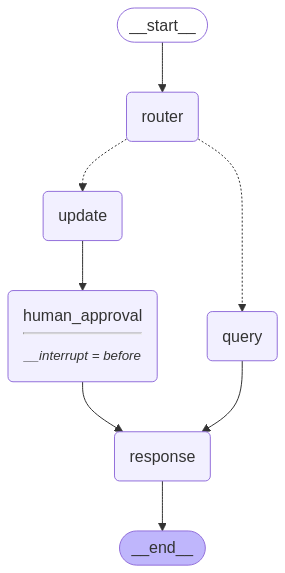

In [36]:
display(Image(music_store_app.get_graph().draw_mermaid_png()))

## Test

In [34]:
def process_user_request(user_input: str, customer_id: int):
    """Process a user request through the graph."""
    initial_state = {
        "messages": [HumanMessage(content=user_input)],
        "customer_id": customer_id,
        "next_node": NodeType.ROUTER,
        "tool_results": None,
        "update_proposal": None,
        "approved": None,
        "error": None
    }
    
    final_state = music_store_app.invoke(initial_state)
    return final_state

In [35]:
query_request = "Show my contact information?"
query_result = process_user_request(query_request, customer_id=12)
print("Query result:", query_result["messages"][-1].content)

ValueError: Last message is not an AIMessage

In [ ]:
# Example update request
update_request = "Please update my address to 456 Oak Street"
update_result = process_user_request(update_request, customer_id=12)
print("Update result:", update_result["messages"][-1].content)